The final notebook in the series focused on analyzing the results of extracting impact sentences using BART large MNLI specifically by checking if the assumed threshold is qualified or not. Different ways to visualize the reuslts are shown below, notably are the confusion matrices and the F1 score.

Please ensure to paste the input_path, which is the location of the output of the 01_input.ipynb file, at the start of this notebook. This step is the only requirement to load all necessary information for the execution of the code.

Recommended Google Colab Runtime Type: CPU (default).

In [1]:
# Specify the directory path where the output of the input file 01_input.ipynb was saved
input_path = "/content/drive/My Drive/ImpactDataMining/Hurricane_Otis/01_Input"

All the below sections automatically retrieve data from the 01_input.ipynb file, as well as results from previous notebooks in this series. The code is designed to run using this information, so no further edits are required beyond this point.

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from google.colab import drive
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import time

start_time = time.time()

In [4]:
def current_path():
  print("Current working directory")
  print(os.getcwd())
  print()

current_path()
drive.mount('/content/drive')
os.chdir(input_path)
current_path()

Current working directory
/content

Mounted at /content/drive
Current working directory
/content/drive/My Drive/ImpactDataMining/Hurricane_Otis/01_Input



In [5]:
with open('0_input.json', 'r') as file:
    data = json.load(file)
    output_path = data['output_path']
    keywords_non_impact = data['keywords_non_impact']
    threshold = data['threshold']

with open('4_data_labeling.json', 'r') as file:
    data = json.load(file)
    s_struct = data['labeled_data_struct']
    s_comm = data['labeled_data_comm']
    s_both = data['labeled_data_both']

In [6]:
os.makedirs(output_path, exist_ok=True)
os.chdir(output_path)
current_path()

Current working directory
/content/drive/My Drive/ImpactDataMining/Hurricane_Otis/03_Output



In [7]:
with open('1_output.json', 'r') as file:
    data = json.load(file)
    idx_body = data['idx_body']
    idx_table = data['idx_table']

with open('2a_output.json', 'r') as file:
    data = json.load(file)
    sent_all = data['sent_all']
    keywords = data['labels']
    label_pred = data['result_probs']
    result_labels = data['result_labels']

In [8]:
data_struct = s_struct + s_both
data_comm = s_comm + s_both
data_impact = s_struct + s_comm + s_both

In [9]:
for i, n in enumerate(result_labels):
  if n in keywords_non_impact:
    label_pred[i] = 0

In [10]:
y_true = [1 if n in data_impact else 0 for n in sent_all]
y_pred_6 = [1 if n >= .6 else 0 for n in label_pred]
y_pred_7 = [1 if n >= .7 else 0 for n in label_pred]
y_pred_8 = [1 if n >= .8 else 0 for n in label_pred]
y_pred_9 = [1 if n >= .9 else 0 for n in label_pred]

In [11]:
def confusion_matrix_para(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    confusion_mat = confusion_matrix(y_true, y_pred)

    return acc, pre, rec, f1, confusion_mat

In [12]:
acc_6, pre_6, rec_6, f1_6, confusion_mat_6 = confusion_matrix_para(y_true, y_pred_6)
acc_7, pre_7, rec_7, f1_7, confusion_mat_7 = confusion_matrix_para(y_true, y_pred_7)
acc_8, pre_8, rec_8, f1_8, confusion_mat_8 = confusion_matrix_para(y_true, y_pred_8)
acc_9, pre_9, rec_9, f1_9, confusion_mat_9 = confusion_matrix_para(y_true, y_pred_9)

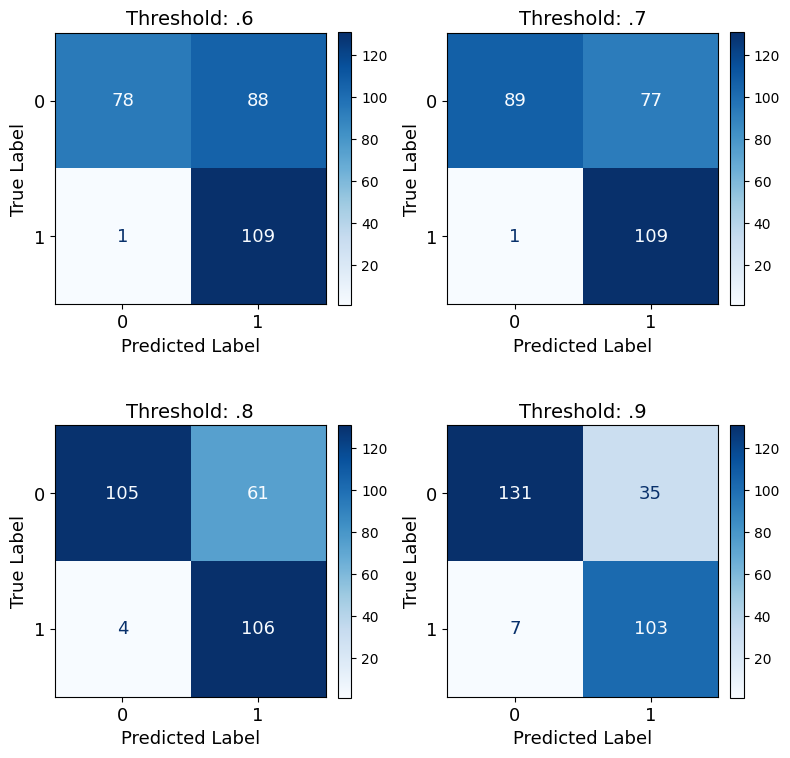

In [13]:
# Stack the confusion matrices
confusion_mat = np.stack((confusion_mat_6, confusion_mat_7, confusion_mat_8, confusion_mat_9))
vmin = np.min(confusion_mat)
vmax = np.max(confusion_mat)
titles = ['Threshold: .6', 'Threshold: .7', 'Threshold: .8', 'Threshold: .9']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # Adjust the overall figure size as needed
axes = axes.flatten()  # Flatten the 2x2 array of axes into a 1D array for easier iteration

for ax, matrix, title in zip(axes, confusion_mat, titles):
    # Plot each confusion matrix in its respective subplot
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['0', '1'])
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d', colorbar=False)

    ax.set_xlabel('Predicted Label', fontsize=13)
    ax.set_ylabel('True Label', fontsize=13)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_title(title, fontsize=14)

    # Increase font size of x-tick and y-tick labels
    ax.tick_params(axis='both', which='major', labelsize=13)

    # Increase font size of numbers inside the confusion matrix
    for text in ax.texts:
        text.set_size(13)

    # Optionally add colorbar to each subplot if needed
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])  # This line is needed to make 'sm' aware of the new norm
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


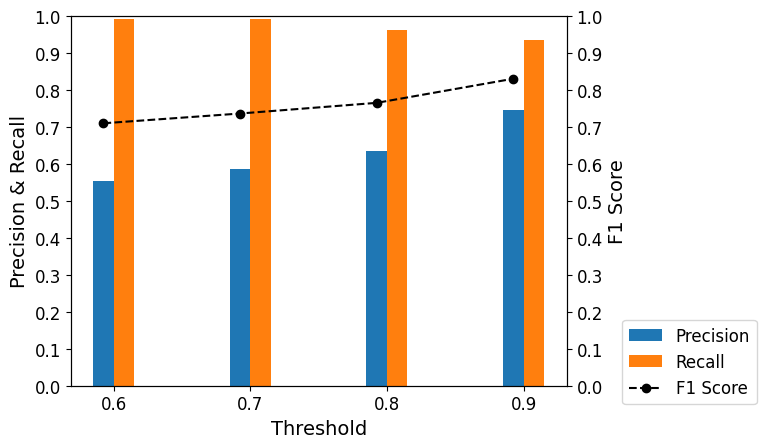

In [14]:
# Create data for each bar chart
acc = [acc_6, acc_7, acc_8, acc_9]
pre = [pre_6, pre_7, pre_8, pre_9]
rec = [rec_6, rec_7, rec_8, rec_9]

F1 = [f1_6, f1_7, f1_8, f1_9]

# Set the positions of the bars on the x-axis
x = range(len(pre))

# Set the width of each bar
width = 0.15

# Create the figure and axis objects
fig, ax1 = plt.subplots()

# Plot the bar charts
ax1.bar(x, pre, width=width, label='Precision')
ax1.bar([val + width for val in x], rec, width=width, label='Recall')

# Adjust the x-tick positions to be at the center between the bars
tick_positions = [val + width/2 for val in x]

# Set the x-axis tick positions and labels
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(['0.6', '0.7', '0.8', '0.9'], fontsize=12)

# Create a second y-axis
ax2 = ax1.twinx()

# Line chart related to the right y-axis
ax2.plot(x, F1, color='k', marker='o', linestyle='--', label='F1 Score')

# Set the y-axis limits
ax1.set_ylim([0, 1])
ax1.set_yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks for ax1
ax1.tick_params(axis='y', labelsize=12)  # Adjust y-tick font size for ax1

ax2.set_ylim([0, 1])
ax2.set_yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks for ax2
ax2.tick_params(axis='y', labelsize=12)  # Adjust y-tick font size for ax2

# Set the title and labels
ax1.set_xlabel('Threshold', fontsize=14)
ax1.set_ylabel('Precision & Recall', fontsize=14)
ax2.set_ylabel('F1 Score', fontsize=14)

# Get the handles and labels from ax1 and ax2
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles += handles2
labels += labels2

# Create a single legend for both ax1 and ax2
plt.legend(handles, labels, bbox_to_anchor=(1.4, 0.2), fontsize=12)

# Show the plot
plt.show()

In [15]:
table = {'Threshold': ['0.6', '0.7', '0.8', '0.9-'],
         'Accuracy': acc,
         'Precision': pre,
         'Recall': rec,
         'F1 Score': F1}
df = pd.DataFrame(table)
df

,Threshold,Accuracy,Precision,Recall,F1 Score
0,0.6,0.677536,0.553299,0.990909,0.710098
1,0.7,0.717391,0.586022,0.990909,0.736486
2,0.8,0.764493,0.634731,0.963636,0.765343
3,0.9-,0.847826,0.746377,0.936364,0.830645


In [16]:
y_pred = [1 if n >= threshold else 0 for n in label_pred]

true_positives = [i for i, (x, y) in enumerate(zip(y_true, y_pred_9)) if x == 1 and y == 1]
true_negatives = [i for i, (x, y) in enumerate(zip(y_true, y_pred_9)) if x == 0 and y == 0]
false_negatives = [i for i, (x, y) in enumerate(zip(y_true, y_pred_9)) if x == 1 and y == 0]
false_positives = [i for i, (x, y) in enumerate(zip(y_true, y_pred_9)) if x == 0 and y == 1]

In [17]:
def display_results(data, idx, result_labels, prob):
  sentences = [data[i] for i in idx]
  labels = [result_labels[i] for i in idx]
  probability = [prob[i] for i in idx]
  data = {'Sentences': sentences, 'Labels': labels, 'Probability': probability}
  df = pd.DataFrame(data)
  return df

In [18]:
print('Sentences with False Positive label')
df_false_positive = display_results(sent_all, false_positives, result_labels, label_pred)
df_false_positive

Sentences with False Positive label


,Sentences,Labels,Probability
0,"overviewing of the hurricane, particularly rel...",building damage,0.903843
1,Hurricane Otis left a trail of destruction in ...,wind-borne debris,0.937784
2,"Additionally, a budget will be reserved to rep...",building damage,0.907204
3,"overviewing of the hurricane, particularly rel...",building damage,0.903843
4,A clear eye and symmetric storm structure is v...,structural behavior,0.980585
5,The station included a sonic anemometer positi...,lateral force resisting systems,0.908059
6,Designs of tall buildings in Acapulco have tra...,structural behavior,0.975159
7,"One of these major hurricanes, Hurricane Pauli...",fatalities,0.971481
8,This hurricane was one of the deadliest Pacifi...,fatalities,0.983923
9,Hurricane Pauline destroyed a great number of ...,bridge damage,0.939933


In [19]:
print('Sentences with False Negative label')
df_false_negative = display_results(sent_all, false_negatives, result_labels, label_pred)
df_false_negative

Sentences with False Negative label


,Sentences,Labels,Probability
0,As a result of these and other related factors...,transaction suspension,0.890982
1,Reports emerged of a shortage of food and drin...,water outage,0.832595
2,"Additionally, one of the most salient impacts ...",family housing damage,0.725283
3,High winds and flooding pose a significant ris...,hurricane strap damage,0.750152
4,"On October 26, out of 513,524 users affected, ...",service loss,0.861833
5,"According to the CFE Bulletin of October 30, 1...",infrastructure resilience,0.798695
6,(It is not clear if these are included in the ...,built-up roofing damage,0.568229


In [20]:
df.to_excel('5_F1score.xlsx', index=False)

In [21]:
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 29.799867868423462 seconds
